
NYC MTA Turnstile Usage Dataset
Have a look at / download the following dataset :
-        Go to http://web.mta.info/developers/turnstile.html
-        This dataset shows entry & exit counter values for each turnstile-device in each station in the NYC Subway System.
-        Note these aren’t counts per interval, but equivalent to an “odometer” reading for each device.
 
*You will be evaluated in terms of coding, data analysis and visualization skills.
 
Data analysis:
-        Which station has the most number of units as of today?
-        What is the total number of entries & exits across the subway system for August 1, 2013?
-        Let’s define the busy-ness as sum of entry & exit count. What station was the busiest on August 1, 2013? What turnstile was the busiest on that date?
-        What stations have seen the most usage growth/decline in 2013?
-        What dates in 2013 are the least busy? Could you identify days in 2013 on which stations were not operating at full capacity or closed entirely?
 


In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import csv
import urllib
import time
import datetime
import seaborn
from datetime import date, timedelta

import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
%matplotlib inline
p = seaborn.color_palette()
pd.set_option('display.max_columns', 120)

### 1.Which station has the most number of units as of today?

In [36]:
station = pd.read_excel('Remote-Booth-Station.xls')
station.head()

,Remote,Booth,Station,Line Name,Division
0,R001,A060,WHITEHALL ST,R1,BMT
1,R001,A058,WHITEHALL ST,R1,BMT
2,R001,R101S,SOUTH FERRY,R1,IRT
3,R002,A077,FULTON ST,ACJZ2345,BMT
4,R002,A081,FULTON ST,ACJZ2345,BMT


In [37]:
station_unit = station.groupby('Station').Remote.nunique()

In [89]:
print "The most number of units:", station_unit[station_unit == station_unit.max()]

The most number of units: Station
86 ST       5
CANAL ST    5
Name: Remote, dtype: int64


### 2.What is the total number of entries & exits across the subway system for August 1, 2013?

In [568]:
file_url =  "http://web.mta.info/developers/data/nyct/turnstile/turnstile_"
url = file_url + '130803' +'.txt'


data = urllib.urlopen(url)
Aug= []
nextday= 0
for line in data:
    line = str(line).rstrip().split(',')
    for i in range(3, len(line), 5):
            day = line[i]
            if day != nextday:      
                Aug.append(line[0:3] + line[i:i+5])
                nextday = day
labels = ['C/A', 'UNIT', 'SCP', 'DATE', 'TIME', 'DESC', 'ENTRIES', 'EXITS']


aggAug = pd.DataFrame.from_records(Aug, columns=labels)

In [570]:
def dailyrows(df):
    #df = df[df['TIME'] == '00:00:00']
    df['DAILY_ENTRIES'] = df.ENTRIES.shift(-1) - df.ENTRIES
    df['DAILY_EXITS'] = df.EXITS.shift(-1) - df.EXITS
    df.loc[pd.to_datetime(df.DATE, format = '%m-%d-%y') + timedelta(days = 1) != 
               pd.to_datetime(df.DATE.shift(-1), format = '%m-%d-%y'), 
           'DAILY_ENTRIES', ] = df.DAILY_ENTRIES.shift(1)   
    df.loc[pd.to_datetime(df.DATE, format = '%m-%d-%y') + timedelta(days = 1) != 
               pd.to_datetime(df.DATE.shift(-1), format = '%m-%d-%y'), 
           'DAILY_EXITS', ] = df.DAILY_EXITS.shift(1)
    df.loc[df.DAILY_ENTRIES < 0, 'DAILY_ENTRIES'] = df.ENTRIES.shift(-1)
    df.loc[df.DAILY_EXITS < 0, 'DAILY_EXITS'] = df.EXITS.shift(-1)
    return df

In [571]:
aggAug[['ENTRIES','EXITS']] = aggAug[['ENTRIES','EXITS']].apply(pd.to_numeric)
#Extract the daily values
Aug = dailyrows(aggAug)
#Since about half of the values are more than 700, so we choose 700 to be an estimation. 
Aug.loc[Aug.DAILY_ENTRIES > 1000000, 'DAILY_ENTRIES'] = 700
Aug.loc[Aug.DAILY_EXITS > 1000000, 'DAILY_EXITS'] = 700

In [578]:
print "The total number for daily entries on Aug 1st is", Aug.DAILY_ENTRIES[Aug.DATE == '08-01-13'].sum()

The total number for daily entries on Aug 1st is 5564400.0


In [579]:
print "The total number for daily exits on Aug 1st is", Aug.DAILY_EXITS[Aug.DATE == '08-01-13'].sum()

The total number for daily exits on Aug 1st is 4405117.0


### 3.Let’s define the busy-ness as sum of entry & exit count. What station was the busiest on August 1, 2013? What turnstile was the busiest on that date?

In [580]:
#Add the BUSY_NESS column values
Aug['BUSYNESS'] = Aug['DAILY_ENTRIES'] + Aug['DAILY_EXITS']
#Import station data
station = pd.read_excel('Remote-Booth-Station.xls')
station = station.iloc[:,:3]
station.columns = ['UNIT', 'C/A', 'STATION']
#Merge with station data file
mergeAug = Aug.merge(station, how = 'left', on = ['C/A', 'UNIT'])
Aug1_Busy = mergeAug[mergeAug.DATE == '08-01-13'].groupby(['STATION'], sort=False)['BUSYNESS'].sum()
Aug1_Busy[Aug1_Busy == Aug1_Busy.max()]


STATION
34 ST-PENN STA    331043.0
Name: BUSYNESS, dtype: float64

In [588]:
Turnstile = mergeAug[mergeAug.DATE == '08-01-13']
Turnstile[Turnstile.index == Turnstile.BUSYNESS.idxmax()]

,C/A,UNIT,SCP,DATE,TIME,DESC,ENTRIES,EXITS,DAILY_ENTRIES,DAILY_EXITS,BUSYNESS,STATION
8153,N063A,R011,00-00-00,08-01-13,00:00:00,REGULAR,13558408,47360109,1882.0,9963.0,11845.0,42 ST-PA BUS TE


####  So the busiest station on August 1 is 34 ST-PENN STA, and the busiest turnstile on that date is the ( C/A = N063A, UNIT = R011, SCP = 00-00-00)

### 4.What stations have seen the most usage growth/decline in 2013?

In [ ]:
file_url =  "http://web.mta.info/developers/data/nyct/turnstile/turnstile_"

#Change the time format
def formatDate(date):
    return date.strftime("%y%m%d")
firstday = datetime.date(2013,1,5)
lastday = datetime.date(2013,12,28)
date = firstday
aggData=[]
nextday = 0
#Aggregate all the data in 2013 
while date <= lastday:    
    url = file_url + formatDate(date) +'.txt'
    txtdata = urllib.urlopen(url)
    for line in txtdata:
        line = str(line).rstrip().split(',')
        for i in range(3, len(line), 5):
            day = line[i]
            if day != nextday:
                aggData.append(line[0:3] + line[i:i+5])
                nextday = day
    date += datetime.timedelta(days=7)
    time.sleep(5)   #For the break 
    
labels = ['C/A', 'UNIT', 'SCP', 'DATE', 'TIME', 'DESC', 'ENTRIES', 'EXITS']

aggFile = pd.DataFrame.from_records(aggData, columns=labels)

In [4]:
#aggFile.to_csv('aggFile.csv')
aggFile = pd.read_csv('aggFile.csv')
aggFile13 = aggFile[aggFile['DATE'].map(lambda x: x.split('-')[2]) == '13']
#aggFile13.loc[aggFile13.DAILY_ENTRIES > 700]

agg = aggFile13.copy()
agg[['ENTRIES','EXITS']] = agg[['ENTRIES','EXITS']].apply(pd.to_numeric)
agg[['ENTRIES','EXITS']] = agg[['ENTRIES','EXITS']].abs()
def dailyrows(df):
    #df = df[df['TIME'] == '00:00:00']
    df['DAILY_ENTRIES'] = df.ENTRIES.shift(-1) - df.ENTRIES
    df['DAILY_EXITS'] = df.EXITS.shift(-1) - df.EXITS
    df.loc[pd.to_datetime(df.DATE, format = '%m-%d-%y') + timedelta(days = 1) != 
               pd.to_datetime(df.DATE.shift(-1), format = '%m-%d-%y'), 
           'DAILY_ENTRIES', ] = df.DAILY_ENTRIES.shift(1)   
    df.loc[pd.to_datetime(df.DATE, format = '%m-%d-%y') + timedelta(days = 1) != 
               pd.to_datetime(df.DATE.shift(-1), format = '%m-%d-%y'), 
           'DAILY_EXITS', ] = df.DAILY_EXITS.shift(1)
    df.loc[df.DAILY_ENTRIES < 0, 'DAILY_ENTRIES'] = df.ENTRIES.shift(-1)
    df.loc[df.DAILY_EXITS < 0, 'DAILY_EXITS'] = df.EXITS.shift(-1)
    return df

agg = dailyrows(agg)
agg.loc[agg.DAILY_ENTRIES > 1000000, 'DAILY_ENTRIES'] = 700
agg.loc[agg.DAILY_EXITS > 1000000, 'DAILY_EXITS'] = 700
agg.head()

,Unnamed: 0,C/A,UNIT,SCP,DATE,TIME,DESC,ENTRIES,EXITS,DAILY_ENTRIES,DAILY_EXITS
3,3,A002,R051,02-00-00,01-01-13,03:00:00,REGULAR,3932284,1355714,522.0,155.0
4,4,A002,R051,02-00-00,01-02-13,03:00:00,REGULAR,3932806,1355869,1700.0,539.0
5,5,A002,R051,02-00-00,01-03-13,03:00:00,REGULAR,3934506,1356408,1636.0,513.0
6,6,A002,R051,02-00-00,01-04-13,03:00:00,REGULAR,3936142,1356921,1636.0,513.0
10,10,A002,R051,02-00-01,01-01-13,03:00:00,REGULAR,3759294,813099,437.0,121.0


In [6]:
agg['BUSYNESS'] = agg['DAILY_ENTRIES'] + agg['DAILY_EXITS']
merge2013 = agg.merge(station, how = 'left', on = ['C/A', 'UNIT'])

In [617]:
staUsa = merge2013.groupby(['STATION', 'DATE']).BUSYNESS.sum()
print "The station that has seen the most usage growth is", (staUsa.max(level = 0) - staUsa.min(level = 0)).idxmax()

The station that has seen the most usage growth is GROVE STREET


### 5.What dates in 2013 are the least busy? Could you identify days in 2013 on which stations were not operating at full capacity or closed entirely?

In [ ]:
#As we are dealing with only two features here, plotting helps us visualize the least busy points.

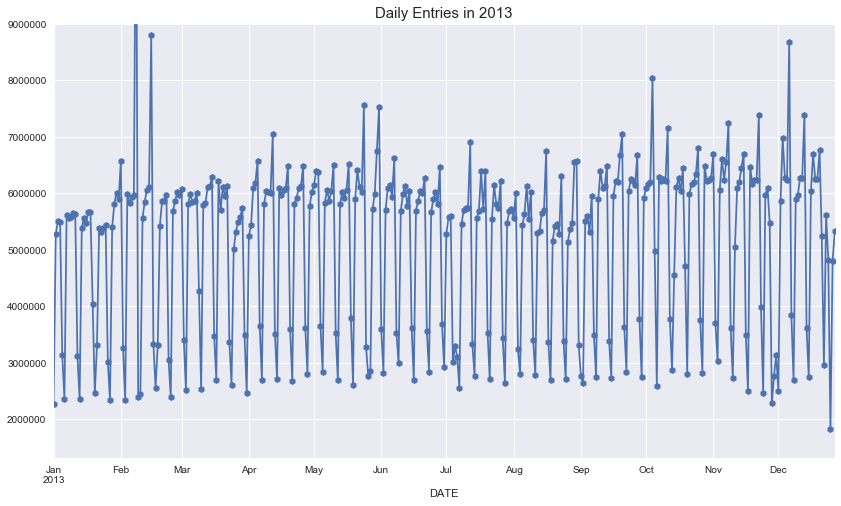

In [658]:
agg.groupby('DATE')['DAILY_ENTRIES'].sum().plot(figsize = (14,8), marker = 'h', title = 'Daily Entries in 2013')
plt.ylim(ymax = 9000000)
plt.title('Daily Entries in 2013',fontsize= 15)


In [638]:
print "The least busy date is:", str(agg.groupby('DATE')['DAILY_ENTRIES'].sum().idxmin()).split(' ')[0]

The least busy date is: 2013-12-25


In [654]:
# Day of week pattern for entries and exits 
agg['day_of_week'] = pd.to_datetime(agg['DATE']).dt.weekday_name

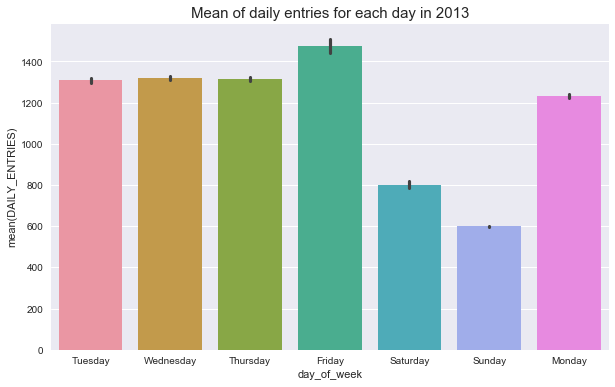

In [688]:
plt.figure(figsize=(10,6))
seaborn.barplot(agg['day_of_week'],agg['DAILY_ENTRIES'])
plt.title('Mean of daily entries for each day in 2013',fontsize= 15)


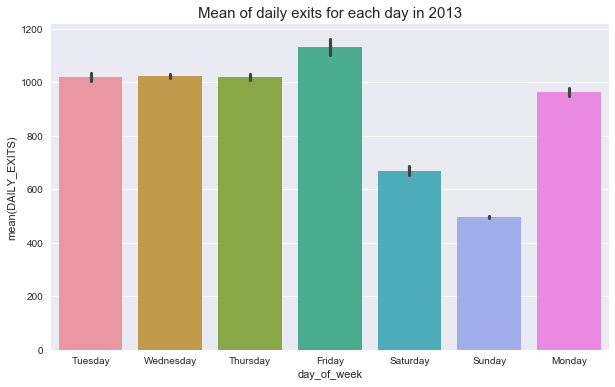

In [689]:
plt.figure(figsize=(10,6))
seaborn.barplot(agg['day_of_week'],agg['DAILY_EXITS'])
plt.title('Mean of daily exits for each day in 2013',fontsize= 15)

#### For the plots above we can see that stations were not operating at full capacity in the Saturday and Sunday. 

### Visualization:
-        Plot the daily row counts for data files in Q3 2013.
-        Plot the daily total number of entries & exits across the system for Q3 2013.
-        Plot the mean and standard deviation of the daily total number of entries & exits for each month in Q3 2013 for station 34 ST-PENN STA.
-        Plot 25/50/75 percentile of the daily total number of entries & exits for each month in Q3 2013 for station 34 ST-PENN STA.
-        Plot the daily number of closed stations and number of stations that were not operating at full capacity in Q3 2013.

-        Plot the daily row counts for data files in Q3 2013.


In [ ]:
file_url =  "http://web.mta.info/developers/data/nyct/turnstile/turnstile_"


#Copy previous function
def formatDate(date):
    return date.strftime("%y%m%d")

firstday = datetime.date(2013,1,5)
lastday = datetime.date(2013,12,28)

date = firstday
aggData=[]

#For row counts, we need to extract all the rows in a day
#Different from the former way
while date <= lastday:    
    url = file_url + formatDate(date) +'.txt'
    data = urllib.urlopen(url)
    for line in data:
        line = str(line).rstrip().split(',')
        for i in range(3, len(line), 5):
            aggData.append(line[0:3] + line[i:i+5])
    date += datetime.timedelta(days=7)
    time.sleep(5)   
labels = ['C/A', 'UNIT', 'SCP', 'DATE', 'TIME', 'DESC', 'ENTRIES', 'EXITS']

aggAll = pd.DataFrame.from_records(aggData, columns=labels)
#aggAll.to_csv('aggAll.csv')

In [ ]:
#Filter the data for 2013
agg2013 = aggAll[aggAll['DATE'].map(lambda x: x.split('-')[2]) == '13']

agg2013[['ENTRIES','EXITS']] = agg2013[['ENTRIES','EXITS']].apply(pd.to_numeric)
agg2013[['ENTRIES','EXITS']] = agg2013[['ENTRIES','EXITS']].abs()
def dailyrows(df):
    #df = df[df['TIME'] == '00:00:00']
    df['DAILY_ENTRIES'] = df.ENTRIES.shift(-1) - df.ENTRIES
    df['DAILY_EXITS'] = df.EXITS.shift(-1) - df.EXITS
    df.loc[pd.to_datetime(df.DATE, format = '%m-%d-%y') + timedelta(days = 1) != 
               pd.to_datetime(df.DATE.shift(-1), format = '%m-%d-%y'), 
           'DAILY_ENTRIES', ] = df.DAILY_ENTRIES.shift(1)   
    df.loc[pd.to_datetime(df.DATE, format = '%m-%d-%y') + timedelta(days = 1) != 
               pd.to_datetime(df.DATE.shift(-1), format = '%m-%d-%y'), 
           'DAILY_EXITS', ] = df.DAILY_EXITS.shift(1)
    df.loc[df.DAILY_ENTRIES < 0, 'DAILY_ENTRIES'] = df.ENTRIES.shift(-1)
    df.loc[df.DAILY_EXITS < 0, 'DAILY_EXITS'] = df.EXITS.shift(-1)
    return df

agg2013 = dailyrows(agg2013)
agg2013.loc[agg2013.DAILY_ENTRIES > 1000000, 'DAILY_ENTRIES'] = 700
agg2013.loc[agg2013.DAILY_EXITS > 1000000, 'DAILY_EXITS'] = 700

In [ ]:
agg2013['DATE'] = agg2013['DATE'].apply(lambda x: 
                                  datetime.datetime.strptime(x,'%m-%d-%y'))
agg2013['quarter'] = agg2013['DATE'].dt.quarter

#Filter the data with quarter function
aggRowQ3 = agg2013[agg2013.quarter == 3]

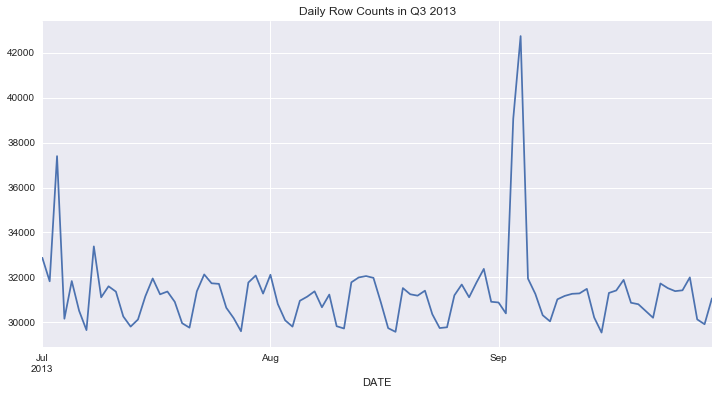

In [477]:
aggRowQ3.groupby('DATE').size().plot(figsize = (12,6),  title = 'Daily Row Counts in Q3 2013' )

-        Plot the daily total number of entries & exits across the system for Q3 2013.


In [7]:
agg['DATE'] = agg['DATE'].apply(lambda x: 
                                    datetime.datetime.strptime(x,'%m-%d-%y'))
agg['quarter'] = agg['DATE'].dt.quarter
aggQ3 = agg[agg.quarter == 3]
aggsum3 = aggQ3.groupby('DATE')['DAILY_ENTRIES','DAILY_EXITS'].sum()

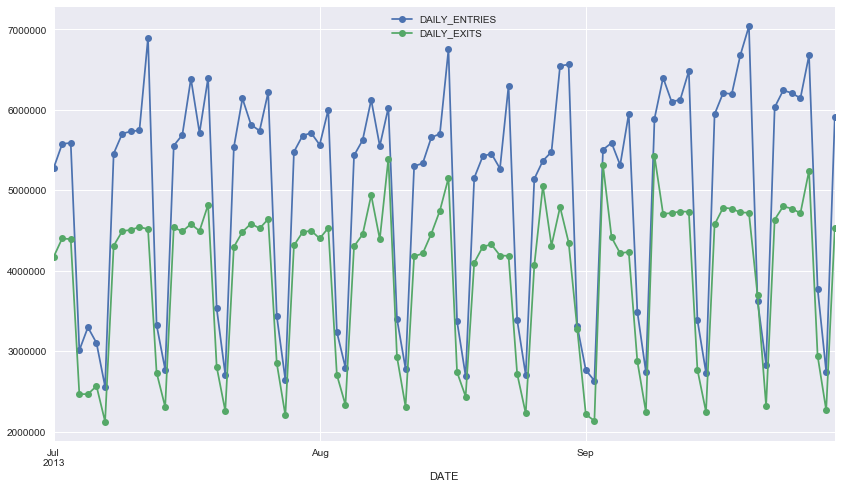

In [672]:
aggsum3.plot(figsize=(14, 8), marker = 'o', legend = True)

#### From the plot we can see that the daily entries and daily exits show the similar trend which makes sense in real life, however, all the daily entries are higher than the daily exits. Maybe there is machine problem or management problems needed to be fixed.  

-        Plot the mean and standard deviation of the daily total number of entries & exits for each month in Q3 2013 for station 34 ST-PENN STA.

In [10]:
aggQ3["month"] = aggQ3["DATE"].map(lambda x: x.month)
Q3merge = aggQ3.merge(station, how = 'left', on = ['C/A', 'UNIT'])
#Q3merge = Q3merge.drop('Unnamed: 0' ,1)

Q3_34penn = Q3merge[Q3merge['STATION'] == '34 ST-PENN STA']
mean = Q3_34penn.groupby('month')['DAILY_ENTRIES','DAILY_EXITS'].mean()
std = Q3_34penn.groupby('month')['DAILY_ENTRIES','DAILY_EXITS'].std()

/Users/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


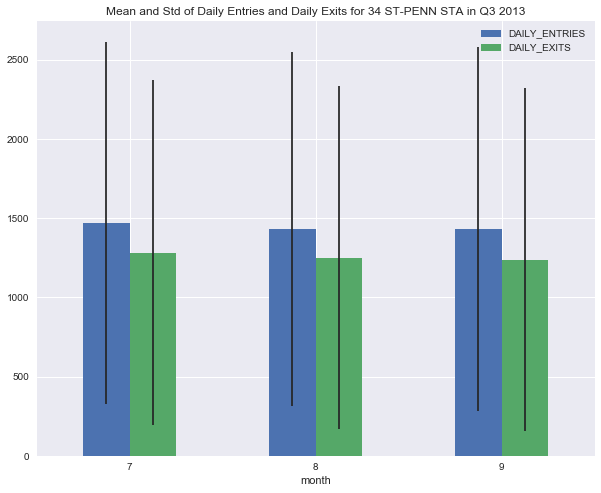

In [505]:
mean.plot(yerr=std, kind='bar',figsize=(10, 8), rot = 0 , title = 'Mean and Std of Daily Entries and Daily Exits for 34 ST-PENN STA in Q3 2013')


#### This plot shows that daily entries and daily exits show the roughly same mean and standard deviation while the July data has subtle higher values which may be because of increased travelers and events during the summer vacation. Therefore, the MTA could arrange its stations capacity and safety management based on the analysis. 

-        Plot 25/50/75 percentile of the daily total number of entries & exits for each month in Q3 2013 for station 34 ST-PENN STA.

In [546]:
Q3_34pennCo = Q3_34penn.copy()
Q3_34pennCo = Q3_34pennCo[['month','DAILY_ENTRIES', 'DAILY_EXITS']]

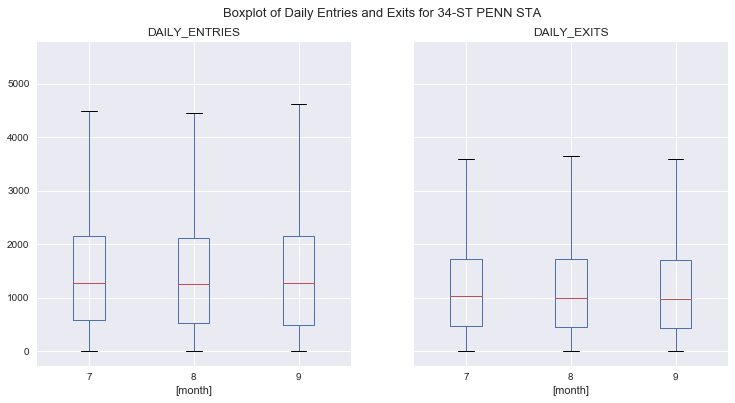

In [666]:
Q3_34pennCo.boxplot(by='month', figsize = (12, 6))
plt.suptitle("Boxplot of Daily Entries and Exits for 34-ST PENN STA",  fontsize = 13)


Plot the daily number of closed stations and number of stations that were not operating at full capacity in Q3 2013.

To figure out the full capacity, we could do the visualization for their distributions.

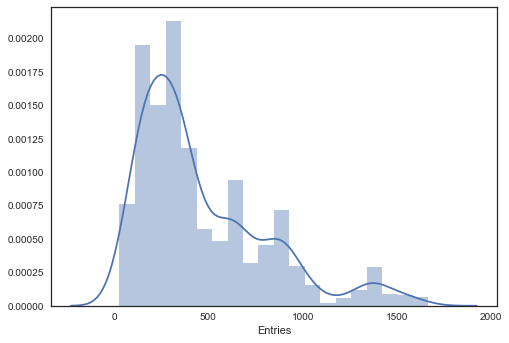

In [101]:
hoty = Q3merge[Q3merge['STATION'] == 'HOYT ST' ][['DATE','DAILY_ENTRIES' ]]
datah = hoty.set_index('DATE').unstack().reset_index()
datah.columns = ['station','DATE', 'Entries']
sns.distplot(datah.Entries)

(-7007.3969303463136, 10000)

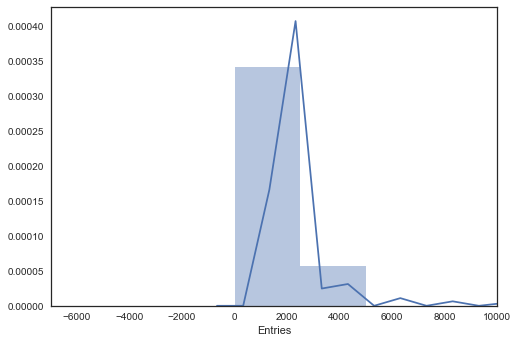

In [270]:
bryant = Q3merge[Q3merge['STATION'] == '42 ST-BRYANT PK'][['DATE','DAILY_ENTRIES' ]]
datab = bryant.set_index('DATE').unstack().reset_index()
datab.columns = ['station','DATE', 'Entries']
sns.distplot(datab.Entries)
plt.xlim(xmax = 10000)

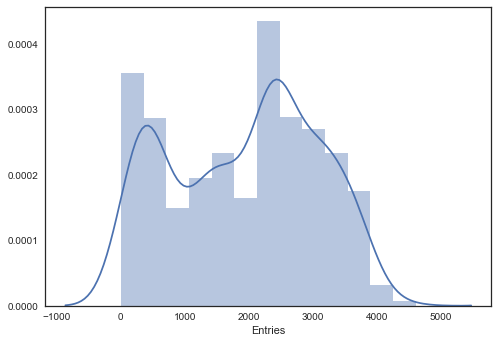

In [99]:
grand = Q3merge[Q3merge['STATION'] == 'GRAND ST'][['DATE','DAILY_ENTRIES' ]]
datag = grand.set_index('DATE').unstack().reset_index()
datag.columns = ['station','DATE', 'Entries']
sns.distplot(datag.Entries)

#### Since different stations show different distributions, we can use unsupervised learning methods such as KMeans to identify the anomolies. 

In [50]:
s = Q3merge.groupby(['STATION', 'DATE'])['BUSYNESS'].sum()

In [170]:
s.mean(level = 0).sort_values().head(20)

STATION
BROAD CHANNEL       278.141304
ORCHARD BEACH       528.852941
TOMPKINSVILLE       651.032609
BEACH 105 ST        708.065217
AQUEDUCT TRACK      943.152174
BEACH 44 ST        1015.402174
E 143 ST           1475.760870
BEACH 36 ST        1478.554348
PATH WTC 2         1597.173913
NEPTUNE AVE        1810.630435
ROCKAWAY PK 116    1823.391304
22 AVE-BAY PKY     1841.923913
BEACH 90 ST        1870.956522
CYPRESS HILLS      1990.097826
MIDDLETOWN ROAD    2066.967391
VAN ALSTON-21ST    2153.391304
OXFORD-104 ST      2505.130435
BUSHWICK AVE       2515.076087
215 ST             2579.858696
HOWARD BCH-JFK     2654.869565
Name: BUSYNESS, dtype: float64

In [ ]:
#### From the sorted values we can estimate that the closed station had busyness below 30 each day. (If 90 days in Q3)

In [276]:
stationSum = s.to_frame().reset_index()


s2 = stationSum[stationSum['BUSYNESS'] > 30 ]


stationSum['CLOSE'] = [1 if x < 30 else 0 for x in stationSum['BUSYNESS']]

In [277]:
import sklearn.cluster as cluster

# KMeans:
KM=cluster.KMeans(n_clusters=2)
KM_labels = []
for i in s2.STATION.unique():
    subdata = s2[s2['STATION'] == i]
    KM.fit(subdata.iloc[:,-1].reshape(-1,1))
    res_KM=KM.predict(subdata.iloc[:,-1].reshape(-1,1))
    KM_labels.append(res_KM)

klabel = KM_labels
klabel = np.concatenate(klabel).ravel()
s2['KM_labels'] = klabel

# Guassian Mixture:
from sklearn.mixture import GaussianMixture
GM=GaussianMixture(n_components=2)
GM_labels = []
for i in s2.STATION.unique():
    subdata = s2[s2['STATION'] == i]
    GM.fit(subdata.iloc[:,-2].reshape(-1,1))
    res_Mix=GM.predict(subdata.iloc[:,-2].reshape(-1,1))
    GM_labels.append(res_Mix)
    

glabel = GM_labels
glabel = np.concatenate(glabel).ravel()
s2['GM_labels'] = glabel

/Users/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [286]:
s2.iloc[100:110,:]

,STATION,DATE,BUSYNESS,KM_labels,GM_labels
100,103 ST,2013-07-09,56862.0,0,0
101,103 ST,2013-07-10,56244.0,0,0
102,103 ST,2013-07-11,56847.0,0,0
103,103 ST,2013-07-12,56847.0,0,0
104,103 ST,2013-07-13,36916.0,1,1
105,103 ST,2013-07-14,32147.0,1,1
106,103 ST,2013-07-15,55642.0,0,0
107,103 ST,2013-07-16,56248.0,0,0
108,103 ST,2013-07-17,57915.0,0,0
109,103 ST,2013-07-18,57122.0,0,0


In [280]:
s2[s2.KM_labels != s2.GM_labels].head(20)

,STATION,DATE,BUSYNESS,KM_labels,GM_labels
185,103 ST-CORONA,2013-07-02,32644.0,1,0
186,103 ST-CORONA,2013-07-03,33743.0,1,0
187,103 ST-CORONA,2013-07-04,22656.0,0,1
188,103 ST-CORONA,2013-07-05,22656.0,0,1
189,103 ST-CORONA,2013-07-06,17996.0,0,1
190,103 ST-CORONA,2013-07-07,14586.0,0,1
191,103 ST-CORONA,2013-07-08,31836.0,1,0
192,103 ST-CORONA,2013-07-09,33532.0,1,0
193,103 ST-CORONA,2013-07-10,33975.0,1,0
194,103 ST-CORONA,2013-07-11,34077.0,1,0


#### From the above dataframe we can see that when GM model is different from the Kmeans model, the 'label = 0'  makes more sense in GM model because most of the 'label = 0' indicates the smaller BUSYNESS value. Therefore we can plot the stations that were not operating full capacity by using the GM model.

(85.349999999999994, 260)

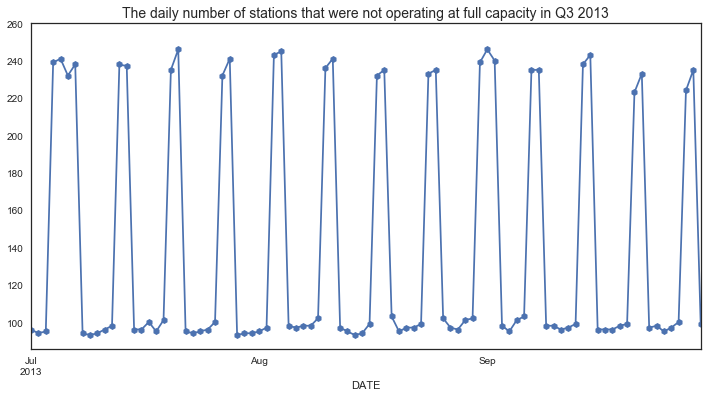

In [289]:
s2.groupby('DATE').GM_labels.sum().plot(figsize = (12,6) , marker = 'h')
plt.title('The daily number of stations that were not operating at full capacity in Q3 2013', size = 14)
plt.ylim(ymax = 260)

(-0.75, 17)

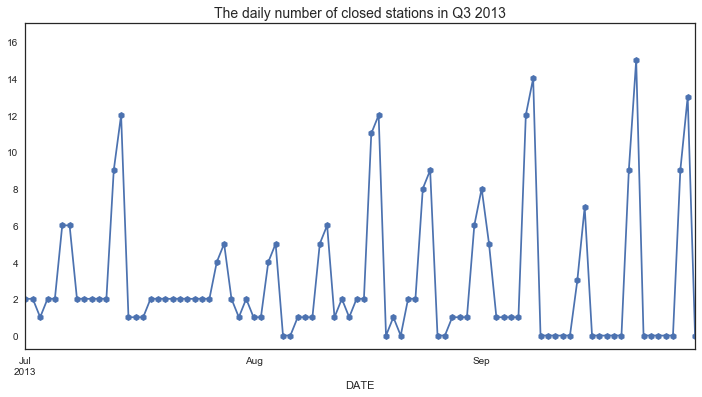

In [290]:
stationSum.groupby('DATE').CLOSE.sum().plot(figsize = (12,6) , marker = 'h')
plt.title('The daily number of closed stations in Q3 2013', size = 14)
plt.ylim(ymax = 17)

#### Based on the data challenge, we can conclude not only the real world daily MTA activities but also their day of week pattern and busyness patterns. In addition, lots of plots and analysis could generate insights for real mangement decisions. For the further step we could possibly focus on several "hot" station balanced problems and various lines' network analysis. 